In [0]:
data_test="/content/drive/My Drive/UCR_TS_Archive_2015/ECG5000/ECG5000_TEST"
data_train="/content/drive/My Drive/UCR_TS_Archive_2015/ECG5000/ECG5000_TRAIN"

In [0]:
import matplotlib.pyplot as plt
# import tensorflow
import numpy as np
import pandas as pd
from tensorflow.python import keras
#from tensorflow import keras
import os
import operator
import functools

In [0]:
def read_dataset(func):
  @functools.wraps(func)
  def dataset(params1, params2):
    data_train = np.loadtxt(params1, delimiter=',')
    data_test = np.loadtxt(params2, delimiter=',')
    train_Y = data_train[:, 0]
    train_X = data_train[:, 1:]
    test_Y = data_test[:, 0]
    test_X = data_test[:, 1:]
    return train_X, train_Y, test_X, test_Y
  return dataset

In [0]:
@read_dataset
def readucr(train_data, test_data):
    return train_X, train_Y, test_X, test_Y

In [0]:
x_train, y_train, x_test, y_test= readucr(data_train, data_test)

In [0]:
x_train

array([[-1.1252e-01, -2.8272e+00, -3.7739e+00, ...,  1.2343e-01,
         9.2529e-01,  1.9314e-01],
       [-1.1009e+00, -3.9968e+00, -4.2858e+00, ...,  7.7382e-01,
         1.1196e+00, -1.4362e+00],
       [-5.6709e-01, -2.5935e+00, -3.8742e+00, ...,  3.2110e-01,
         9.0423e-01, -4.2180e-01],
       ...,
       [-2.1964e-02, -9.1243e-01, -1.9034e+00, ...,  1.4443e+00,
         1.4323e+00,  1.4570e+00],
       [ 2.8801e-01, -1.0980e+00, -2.5002e+00, ...,  4.9872e-02,
         1.0915e-02, -8.1534e-02],
       [-1.1337e+00, -2.7029e+00, -3.1210e+00, ..., -1.1084e-01,
         1.8581e-03, -1.2264e-01]])

In [0]:
X = x_test
Y = y_test
#import seaborn as sns
#sns.set()

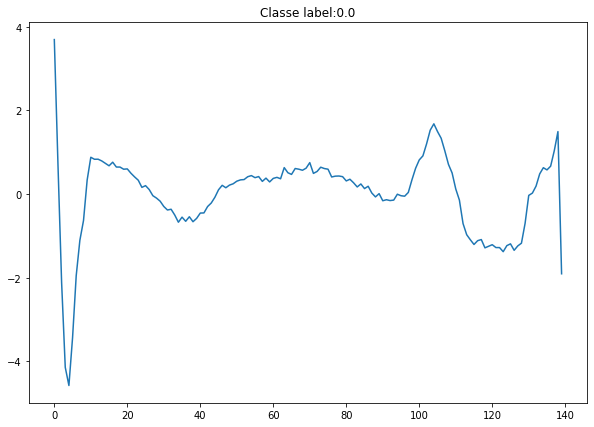

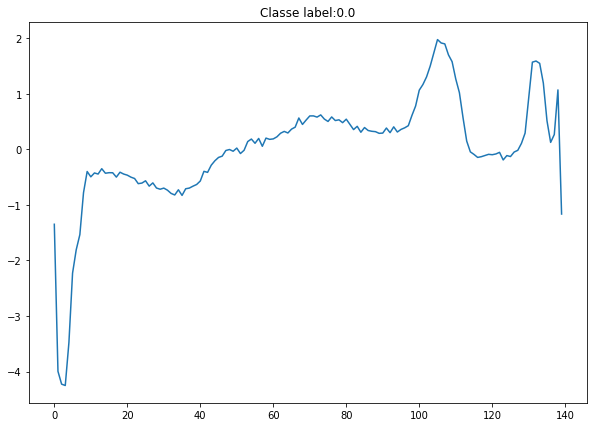

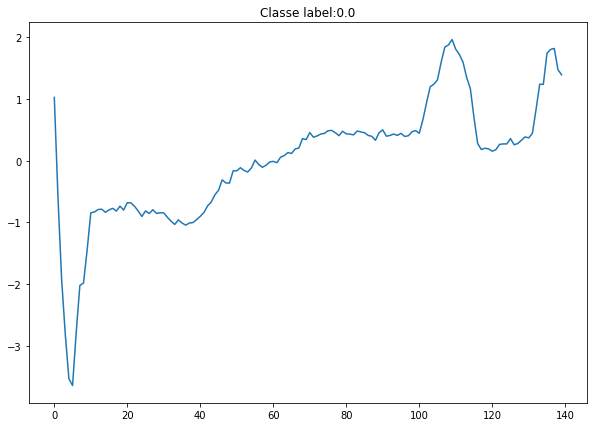

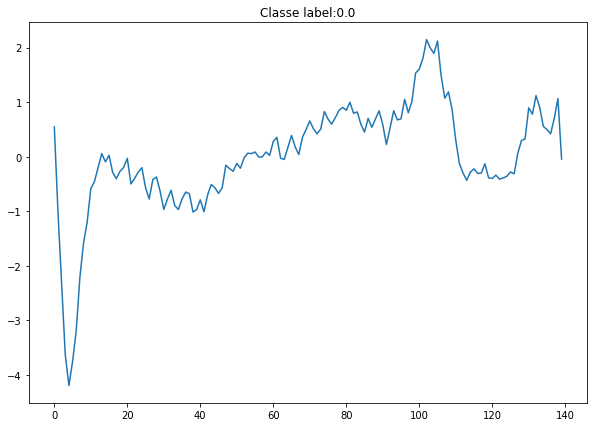

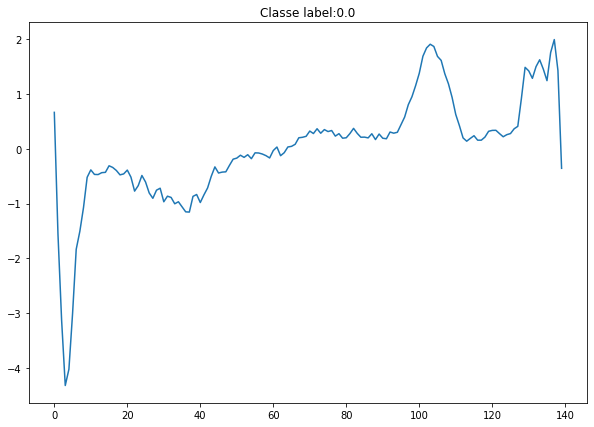

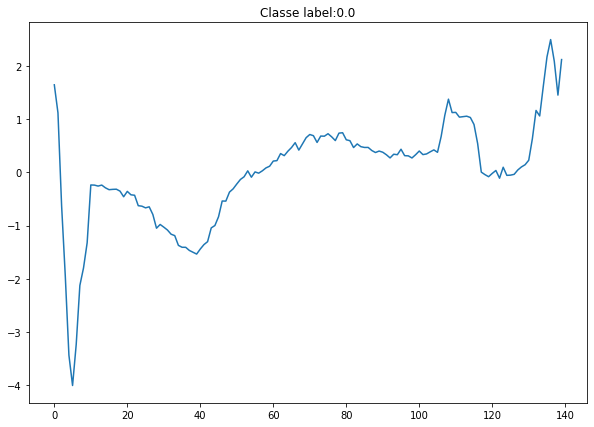

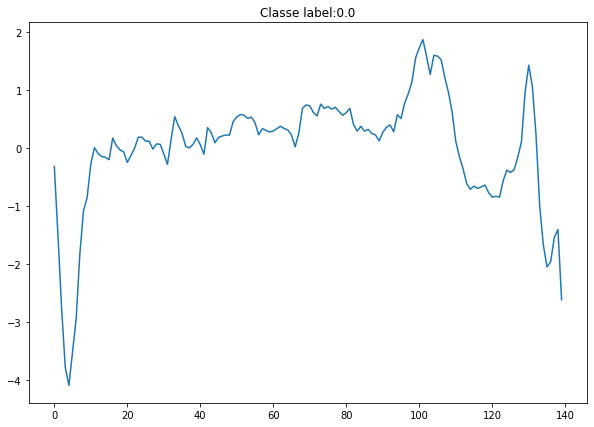

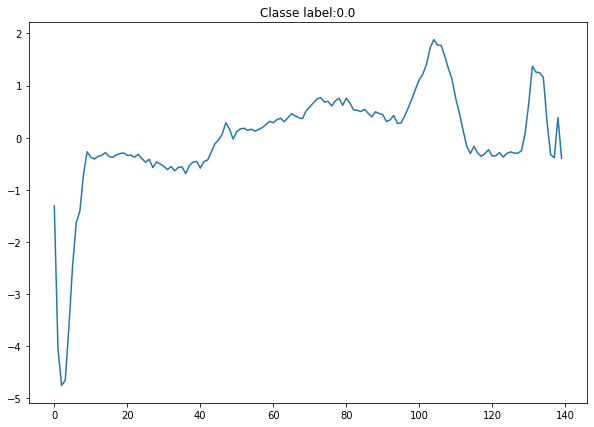

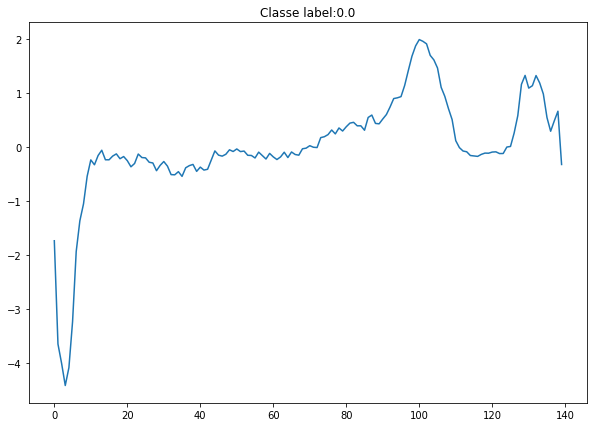

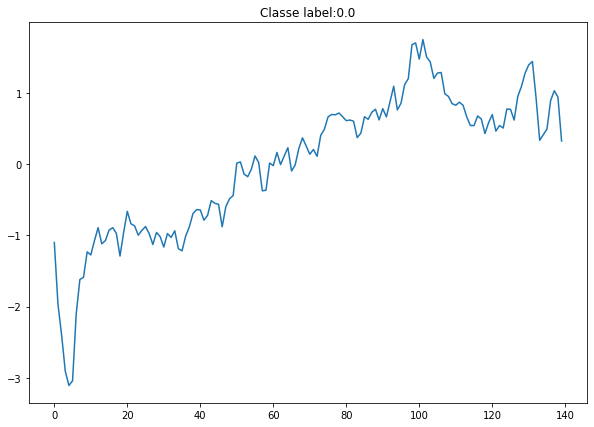

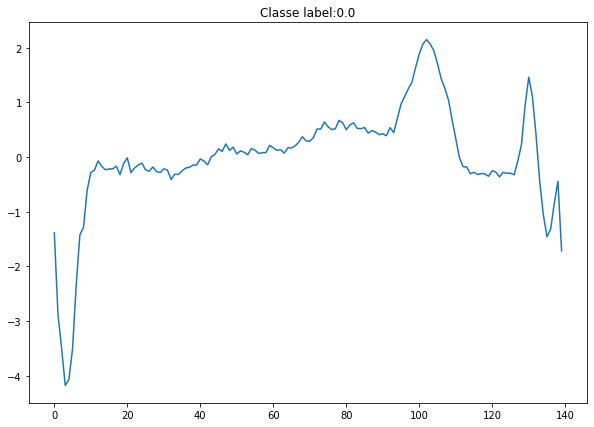

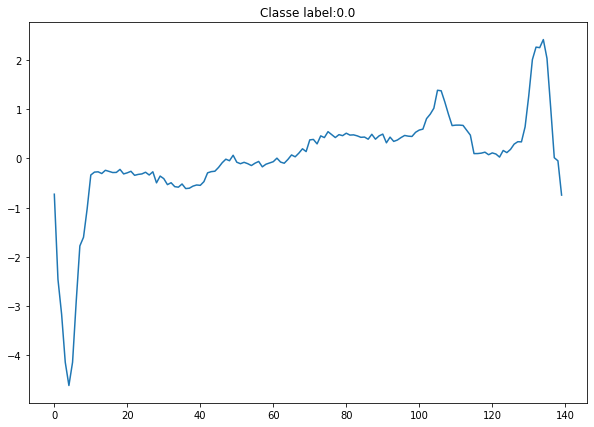

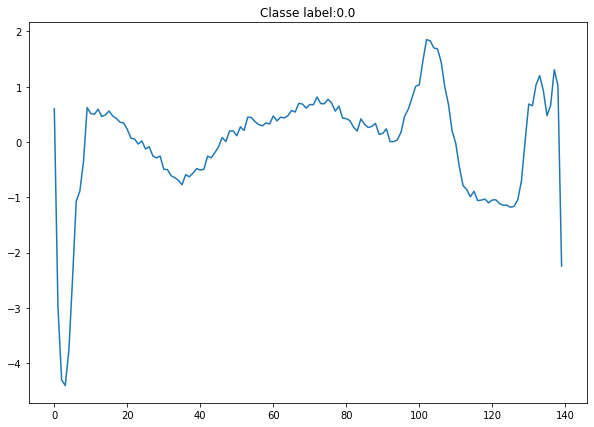

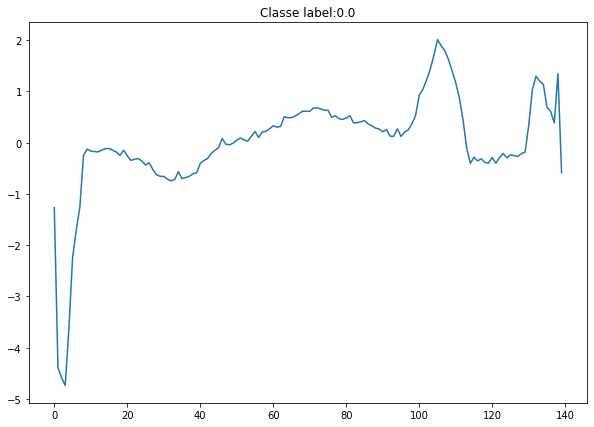

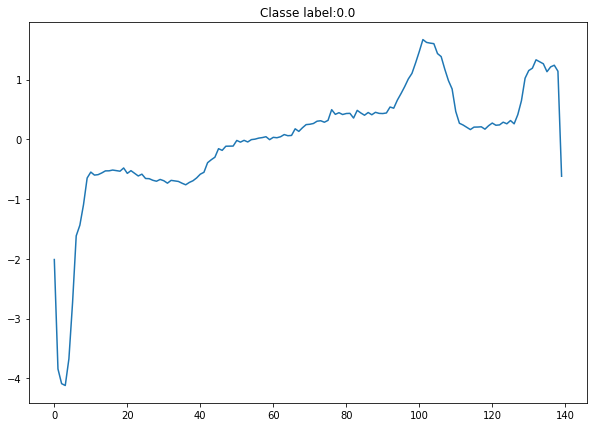

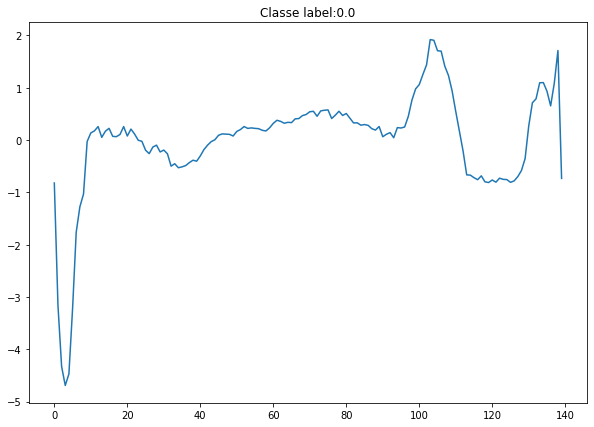

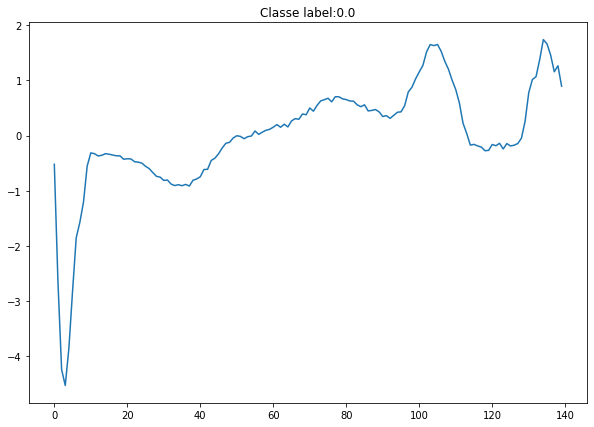

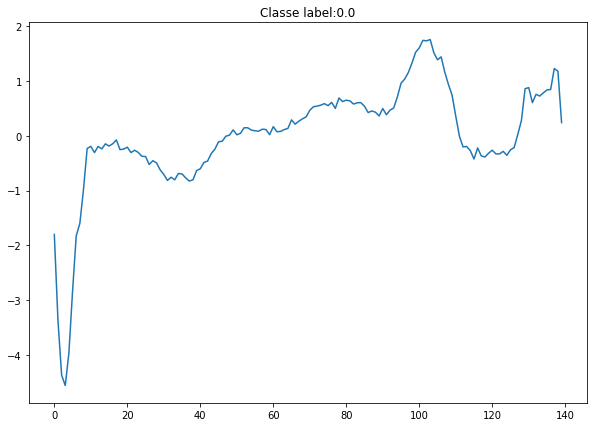

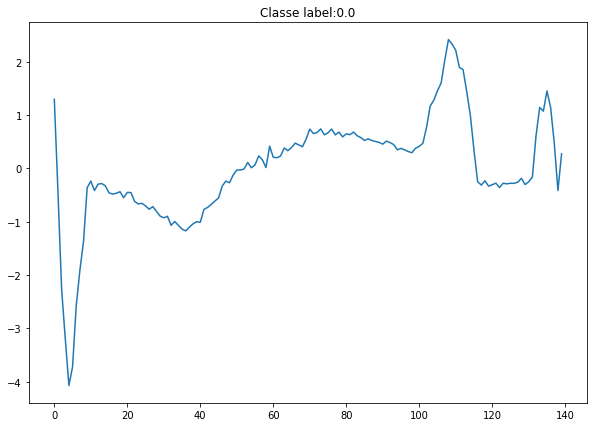

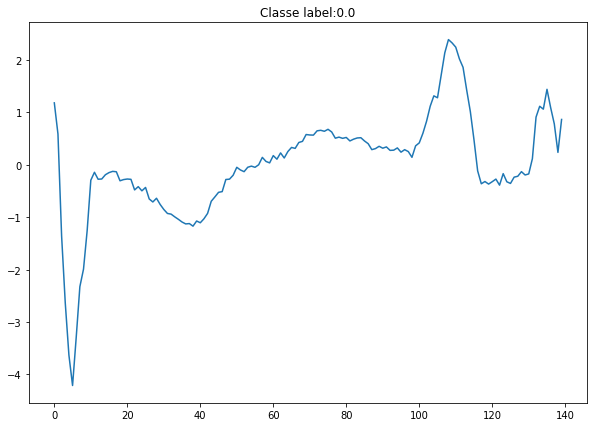

In [0]:
for k in range(20):
   plt.figure(figsize=(10, 7));
   plt.plot(X[k]);
   plt.title(
        'Classe label:' + str(Y[k]-1))
   plt.show()

In [0]:
print(len(x_train))

500


In [0]:
nb_classes =len(set(y_train))
batch_size = min(x_train.shape[0]/10, 16)
nb_classes, batch_size

(5, 16)

In [0]:
y_train = (y_train - y_train.min())/(y_train.max()-y_train.min())*(nb_classes-1)
y_test = (y_test - y_test.min())/(y_test.max()-y_test.min())*(nb_classes-1)

In [0]:
from keras.utils.np_utils import to_categorical
Y_train =to_categorical(y_train, nb_classes)
Y_test = to_categorical(y_test, nb_classes)

Using TensorFlow backend.


In [0]:
Y_train

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)

# z-normalisation des donnees d'apprentissage

In [0]:
x_train_mean = x_train.mean()
x_train_std = x_train.std()
x_train = (x_train - x_train_mean)/(x_train_std)

x_test_mean = x_test.mean()
x_test_std = x_test.std()    
x_test = (x_test - x_test_mean)/(x_test_std)

In [0]:
x_test.shape

(4500, 140)

In [0]:
x_train = x_train.reshape(x_train.shape + (1,1,))
x_test = x_test.reshape(x_test.shape + (1,1,))

In [0]:
x_test.shape

(4500, 140, 1, 1)

In [0]:
def grabocka_params_to_shapelet_size_dict(ts_sz, n_classes, l, r):
    """Compute number and length of shapelets the way it is done in [1]_.
    Parameters
    ----------
    ts_sz: int
        Length of time series in the dataset
    n_classes: int
        Number of classes in the dataset
    l: float
        Fraction of the length of time series to be used for base shapelet length
    r: int
        Number of different shapelet lengths to use
    Returns
    -------
    dict
        Dictionnary giving, for each shapelet length, the number of such shapelets to be generated
    Examples
    --------
    >>> d = grabocka_params_to_shapelet_size_dict(ts_sz=100, n_classes=3, l=0.1, r=2)
    >>> keys = sorted(d.keys())
    >>> print(keys)
    [10, 20]
    >>> print([d[k] for k in keys])
    [3, 3]
    """
    base_size = int(l * ts_sz)
    print(base_size)
    d = {}
    for sz_idx in range(r):
        shp_sz = base_size * (sz_idx + 1)
        n_shapelets = int(np.log10(ts_sz - shp_sz + 1) * (n_classes - 1))
        d[shp_sz] = n_shapelets
    return d

In [0]:
d = grabocka_params_to_shapelet_size_dict(ts_sz=100, n_classes=3, l=0.1, r=2)

10


In [0]:
d

{10: 3, 20: 3}

In [0]:
import tensorflow as tf

tf.compat.v1.disable_eager_execution()
def build_resnet(input_shape, n_feature_maps, nb_classes):
    print ('build conv_x')
    x = keras.layers.Input(shape=(input_shape))
    conv_x = keras.layers.BatchNormalization()(x)
    conv_x = keras.layers.Conv2D(n_feature_maps, 8, 1, padding='same')(conv_x)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)
     
    print ('build conv_y')
    conv_y = keras.layers.Conv2D(n_feature_maps, 5, 1, padding='same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)
     
    print ('build conv_z')
    conv_z = keras.layers.Conv2D(n_feature_maps, 3, 1, padding='same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)
     
    is_expand_channels = not (input_shape[-1] == n_feature_maps)
    if is_expand_channels:
        shortcut_y = keras.layers.Conv2D(n_feature_maps, 1, 1,padding='same')(x)
        shortcut_y = keras.layers.BatchNormalization()(shortcut_y)
    else:
        shortcut_y = keras.layers.BatchNormalization()(x)
    print ('Merging skip connection')
    y = keras.layers.Add()([shortcut_y, conv_z])
    y = keras.layers.Activation('relu')(y)
     
    print ('build conv_x')
    x1 = y
    conv_x = keras.layers.Conv2D(n_feature_maps*2, 8, 1, padding='same')(x1)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)
     
    print ('build conv_y')
    conv_y = keras.layers.Conv2D(n_feature_maps*2, 5, 1, padding='same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)
     
    print ('build conv_z')
    conv_z = keras.layers.Conv2D(n_feature_maps*2, 3, 1, padding='same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)
     
    is_expand_channels = not (input_shape[-1] == n_feature_maps*2)
    if is_expand_channels:
        shortcut_y = keras.layers.Conv2D(n_feature_maps*2, 1, 1,padding='same')(x1)
        shortcut_y = keras.layers.BatchNormalization()(shortcut_y)
    else:
        shortcut_y = keras.layers.BatchNormalization()(x1)
    print ('Merging skip connection')
    y = keras.layers.Add()([shortcut_y, conv_z])
    y = keras.layers.Activation('relu')(y)
     
    print ('build conv_x')
    x1 = y
    conv_x = keras.layers.Conv2D(n_feature_maps*2, 8, 1, padding='same')(x1)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)
     
    print ('build conv_y')
    conv_y = keras.layers.Conv2D(n_feature_maps*2, 5, 1, padding='same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)
     
    print ('build conv_z')
    conv_z = keras.layers.Conv2D(n_feature_maps*2, 3, 1, padding='same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)

    is_expand_channels = not (input_shape[-1] == n_feature_maps*2)
    if is_expand_channels:
        shortcut_y = keras.layers.Conv2D(n_feature_maps*2, 1, 1,padding='same')(x1)
        shortcut_y = keras.layers.BatchNormalization()(shortcut_y)
    else:
        shortcut_y = keras.layers.BatchNormalization()(x1)
    print ('Merging skip connection')
    y = keras.layers.Add()([shortcut_y, conv_z])
    y = keras.layers.Activation('relu')(y)
     
    full = keras.layers.GlobalAveragePooling2D()(y)
    out = keras.layers.Dense(nb_classes, activation='softmax')(full)
    print ('        -- model was built.')
    return x, out

In [0]:
nb_epochs = 1500
x , y = build_resnet(x_train.shape[1:], 64, nb_classes)
model = keras.models.Model(inputs=x, outputs=y)
optimizer = keras.optimizers.Adam()
model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
      
model.summary()

build conv_x
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
build conv_y
build conv_z
Merging skip connection
build conv_x
build conv_y
build conv_z
Merging skip connection
build conv_x
build conv_y
build conv_z
Merging skip connection
        -- model was built.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 140, 1, 1)]  0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 140, 1, 1)    4           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 140, 1, 64)   4160        batch_normalization[0][0]   

In [23]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5,
                  patience=50, min_lr=0.0001) 
hist = model.fit(x_train, Y_train, batch_size=batch_size, nb_epoch=nb_epochs,
      verbose=1, validation_data=(x_test, Y_test), callbacks = [reduce_lr])

Train on 500 samples, validate on 4500 samples
Epoch 1/1500
500/500 [==============================] - 4s 8ms/sample - loss: 0.4596 - accuracy: 0.8640 - val_loss: 1.4550 - val_accuracy: 0.3533 - lr: 0.0010
Epoch 2/1500
500/500 [==============================] - 3s 6ms/sample - loss: 0.2647 - accuracy: 0.9300 - val_loss: 1.5949 - val_accuracy: 0.0391 - lr: 0.0010
Epoch 3/1500
500/500 [==============================] - 3s 6ms/sample - loss: 0.2445 - accuracy: 0.9320 - val_loss: 1.7563 - val_accuracy: 0.0389 - lr: 0.0010
Epoch 4/1500
500/500 [==============================] - 3s 6ms/sample - loss: 0.2135 - accuracy: 0.9420 - val_loss: 2.3188 - val_accuracy: 0.0529 - lr: 0.0010
Epoch 5/1500
500/500 [==============================] - 3s 6ms/sample - loss: 0.2251 - accuracy: 0.9340 - val_loss: 1.6091 - val_accuracy: 0.0496 - lr: 0.0010
Epoch 6/1500
500/500 [==============================] - 3s 6ms/sample - loss: 0.1978 - accuracy: 0.9460 - val_loss: 1.7559 - val_accuracy: 0.0740 - lr: 0.0010

In [24]:
log = pd.DataFrame(hist.history)
print(log.loc[log['loss'].idxmin]['loss'], log.loc[log['loss'].idxmin]['val_accuracy'])

9.212450499035185e-06 0.9273333549499512


In [0]:
test_loss = model.evaluate(x_test, Y_test)

In [0]:
predictions = model.predict(x_test)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1)

In [27]:
pred_labels

array([0, 0, 0, ..., 1, 1, 3])

In [0]:
labels = np.argmax(Y_test, axis = 1)

In [29]:
labels

array([0, 0, 0, ..., 1, 1, 1])

In [30]:
pred_labels[1]

0

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


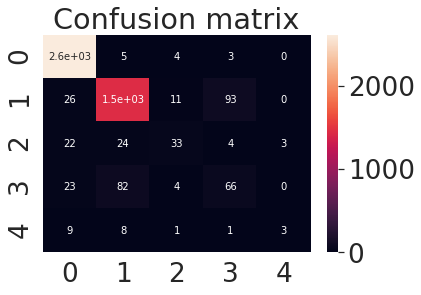

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=2.4)
CM = confusion_matrix(labels, pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=set(labels), 
           yticklabels=set(labels), ax = ax)
ax.set_title('Confusion matrix')
plt.show()

In [0]:
#targets = list(set(labels))

In [0]:
t= [0,1,2,3,4]
target_names = ['0', '1', ' 2', ' 3', ' 4']

In [0]:
pip install numpy scipy scikit-learn==0.19

In [36]:

from sklearn.metrics import classification_report
print(classification_report(labels, pred_labels, target_names=target_names))

classification_report = classification_report(labels, pred_labels, target_names=target_names)

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2627
           1       0.92      0.92      0.92      1590
           2       0.62      0.38      0.47        86
           3       0.40      0.38      0.39       175
           4       0.50      0.14      0.21        22

    accuracy                           0.93      4500
   macro avg       0.68      0.56      0.60      4500
weighted avg       0.92      0.93      0.92      4500



In [0]:
classification_report

In [0]:
def plot_classification_report(classification_report, title='Classification report ', cmap='RdBu'):
    '''
    Plot scikit-learn classification report.
    Extension based on https://stackoverflow.com/a/31689645/395857 
    '''
    lines = classification_report.split('\n')

    classes = []
    plotMat = []
    support = []
    class_names = []
    for line in lines[2 : (len(lines) - 2)]:

        t = line.strip().split()
        if len(t) < 2: continue
        classes.append(t[0])
      
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        print(t)
        plotMat.append(v)

    print('plotMat: {0}'.format(plotMat))
    print('support: {0}'.format(support))

    xlabel = 'Metrics'
    ylabel = 'Classes'
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup) for idx, sup  in enumerate(support)]
    figure_width = 25
    figure_height = len(class_names) + 7
    correct_orientation = False
    heatmap(np.array(plotMat), title, xlabel, ylabel, xticklabels, yticklabels, figure_width, figure_height, correct_orientation, cmap=cmap)
plot_classification_report(classification_report)

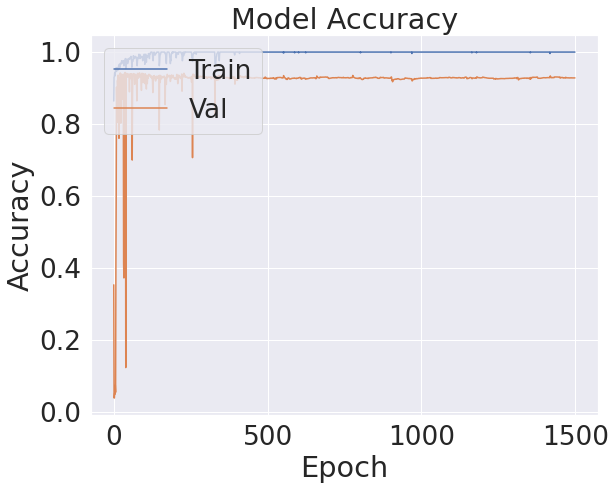

In [37]:
plt.figure(figsize=(20, 7))
plt.subplot(1, 2, 1)
plt.plot(hist.history["accuracy"])
plt.plot(hist.history["val_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Val"], loc="upper left")
plt.show()

In [0]:
#Full connected Network FCN

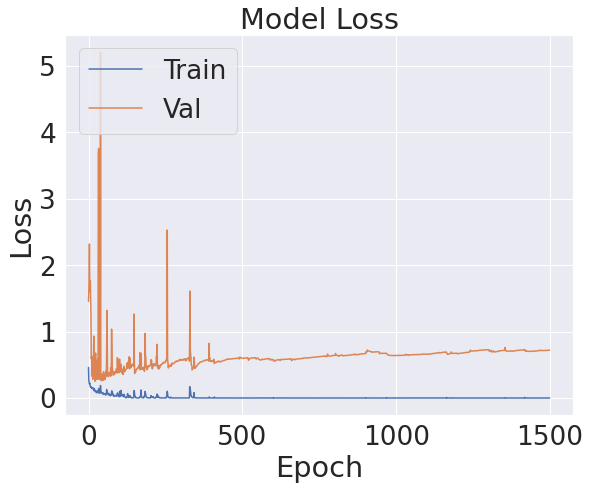

In [38]:
plt.figure(figsize=(20, 7))
plt.subplot(1, 2, 1)
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Val"], loc="upper left")
plt.show()

In [39]:
x = keras.layers.Input(x_train.shape[1:])
#    drop_out = Dropout(0.2)(x)
conv1 = keras.layers.Conv2D(128, 8, 1, padding='same')(x)
conv1 = keras.layers.BatchNormalization()(conv1)
conv1 = keras.layers.Activation('relu')(conv1)
    
#    drop_out = Dropout(0.2)(conv1)
conv2 = keras.layers.Conv2D(256, 5, 1, padding='same')(conv1)
conv2 = keras.layers.BatchNormalization()(conv2)
conv2 = keras.layers.Activation('relu')(conv2)
    
#    drop_out = Dropout(0.2)(conv2)
conv3 = keras.layers.Conv2D(128, 3, 1, padding='same')(conv2)
conv3 = keras.layers.BatchNormalization()(conv3)
conv3 = keras.layers.Activation('relu')(conv3)
    
full = keras.layers.GlobalAveragePooling2D()(conv3)
out = keras.layers.Dense(nb_classes, activation='softmax')(full)
    
    
model = keras.models.Model(inputs=x, outputs=out)
     
optimizer = keras.optimizers.Adam()
model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
     
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 140, 1, 1)]       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 140, 1, 128)       8320      
_________________________________________________________________
batch_normalization_13 (Batc (None, 140, 1, 128)       512       
_________________________________________________________________
activation_9 (Activation)    (None, 140, 1, 128)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 140, 1, 256)       819456    
_________________________________________________________________
batch_normalization_14 (Batc (None, 140, 1, 256)       1024      
_________________________________________________________________
activation_10 (Activation)   (None, 140, 1, 256)       0   

In [40]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor = 'loss', factor=0.5,
                      patience=50, min_lr=0.0001) 
hist = model.fit(x_train, Y_train, batch_size=batch_size, nb_epoch=nb_epochs,
              verbose=1, validation_data=(x_test, Y_test), callbacks = [reduce_lr])
#Print the testing results which has the lowest training loss.
log = pd.DataFrame(hist.history)
print(log.loc[log['loss'].idxmin]['loss'], log.loc[log['loss'].idxmin]['val_accuracy'])


Train on 500 samples, validate on 4500 samples
Epoch 1/1500
500/500 [==============================] - 2s 4ms/sample - loss: 0.6769 - accuracy: 0.8340 - val_loss: 1.5360 - val_accuracy: 0.3533 - lr: 0.0010
Epoch 2/1500
500/500 [==============================] - 1s 2ms/sample - loss: 0.3836 - accuracy: 0.9220 - val_loss: 1.5065 - val_accuracy: 0.3533 - lr: 0.0010
Epoch 3/1500
500/500 [==============================] - 1s 3ms/sample - loss: 0.3157 - accuracy: 0.9140 - val_loss: 1.6405 - val_accuracy: 0.0191 - lr: 0.0010
Epoch 4/1500
500/500 [==============================] - 1s 2ms/sample - loss: 0.3207 - accuracy: 0.9220 - val_loss: 1.7565 - val_accuracy: 0.0191 - lr: 0.0010
Epoch 5/1500
500/500 [==============================] - 1s 2ms/sample - loss: 0.2780 - accuracy: 0.9260 - val_loss: 1.9043 - val_accuracy: 0.0191 - lr: 0.0010
Epoch 6/1500
500/500 [==============================] - 1s 2ms/sample - loss: 0.2694 - accuracy: 0.9240 - val_loss: 2.0012 - val_accuracy: 0.0191 - lr: 0.0010

In [0]:
#import tensorflow as tf
#tf.compat.v1.disable_eager_execution()

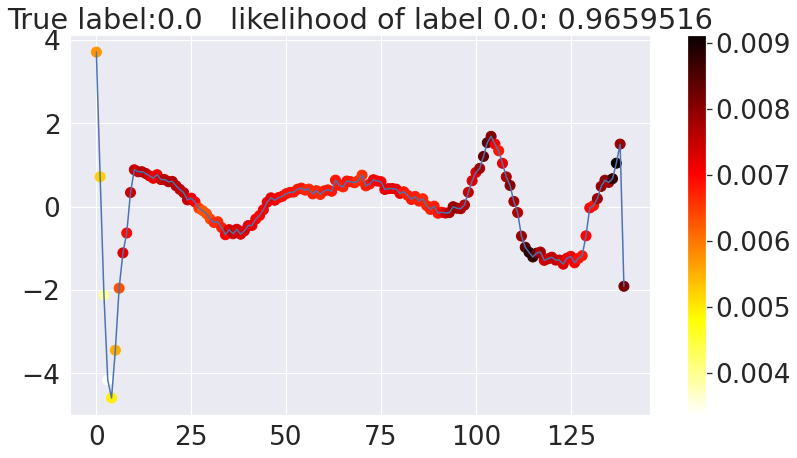

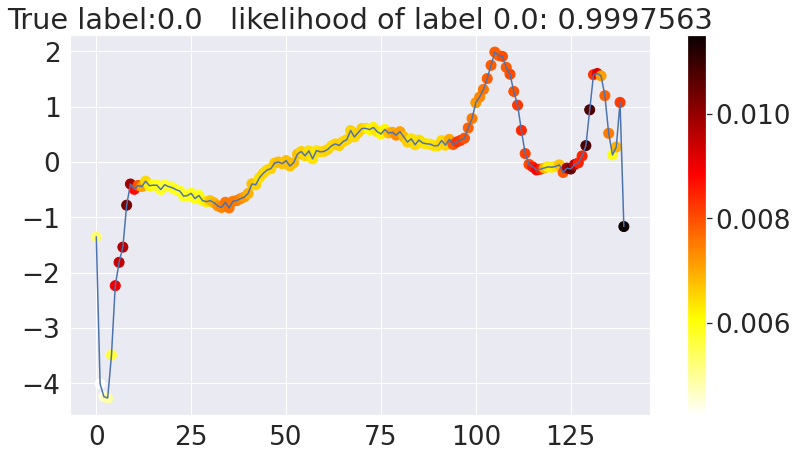

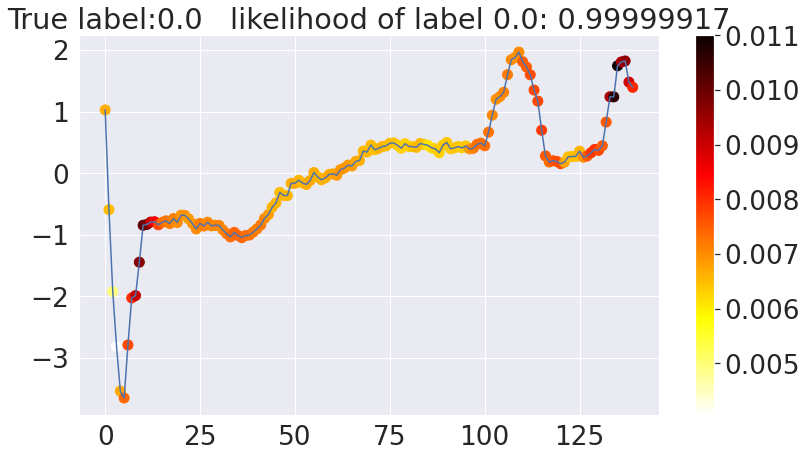

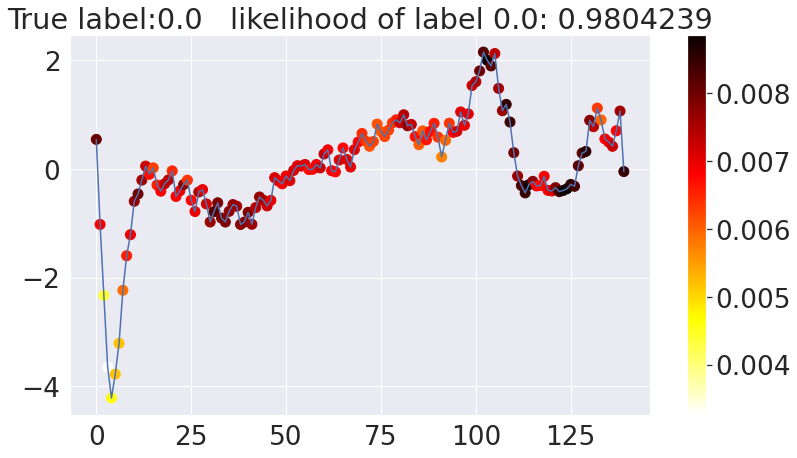

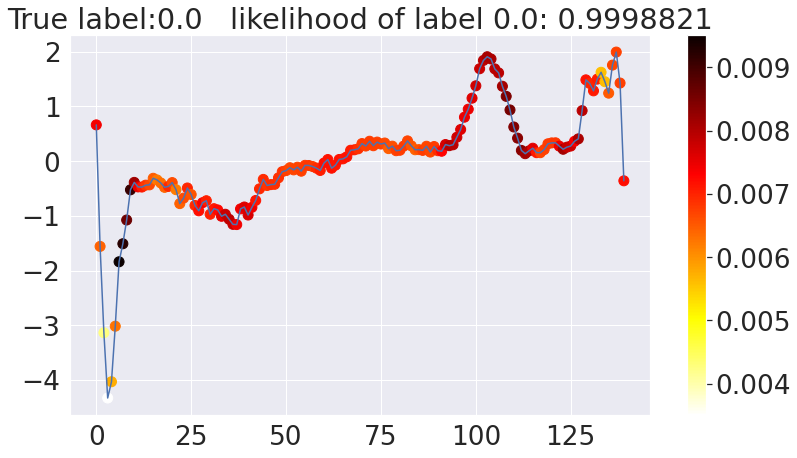

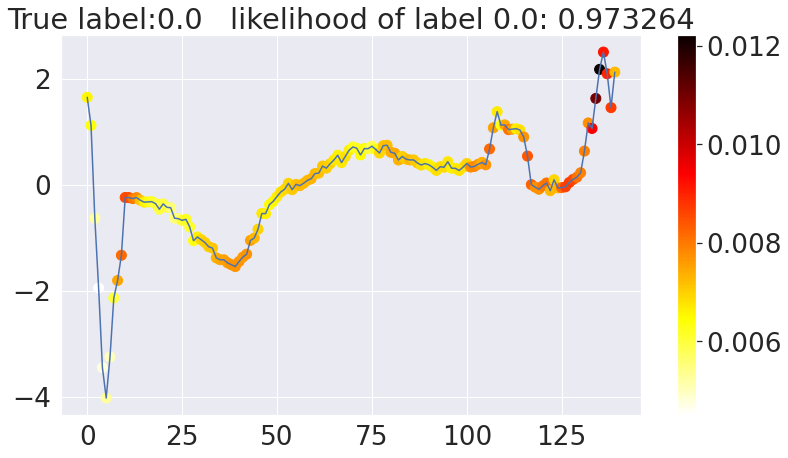

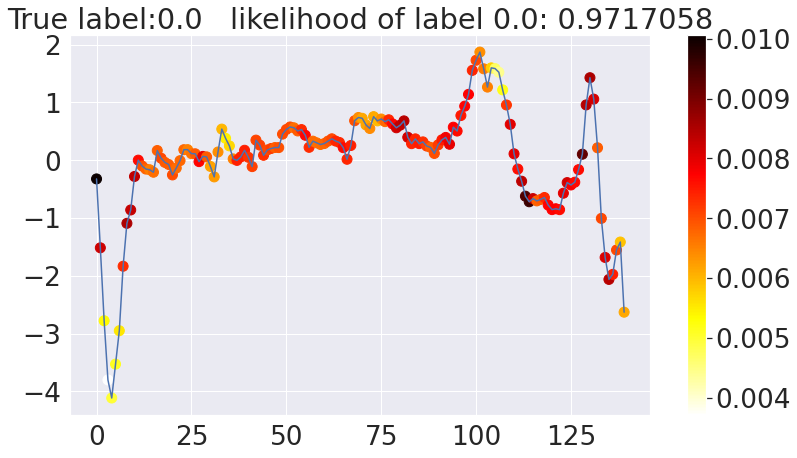

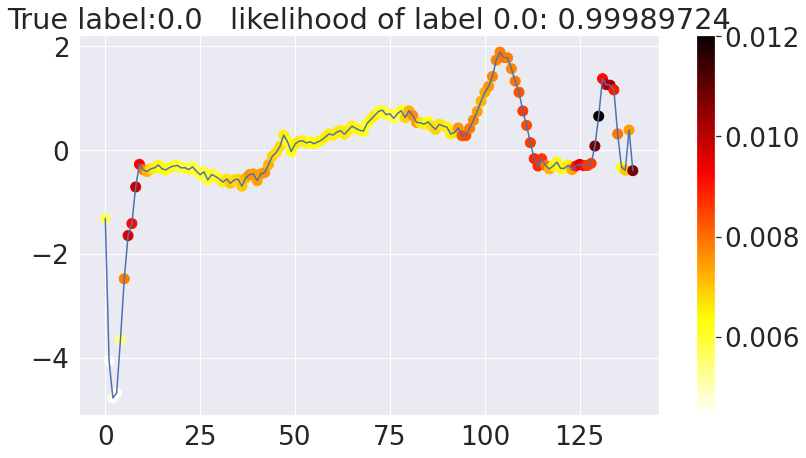

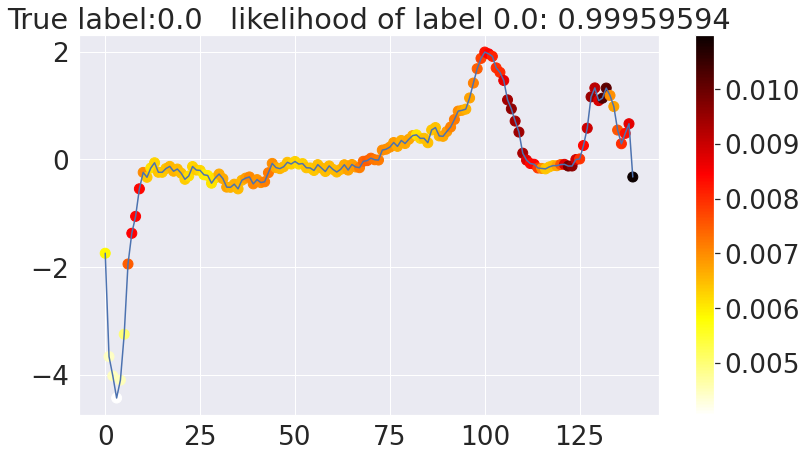

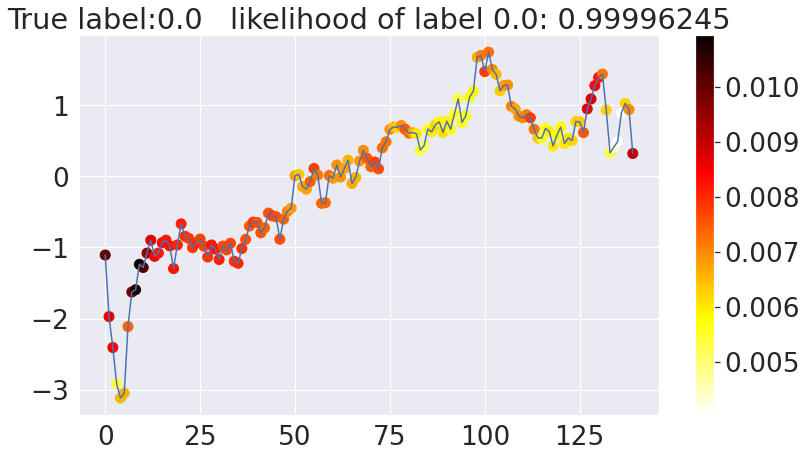

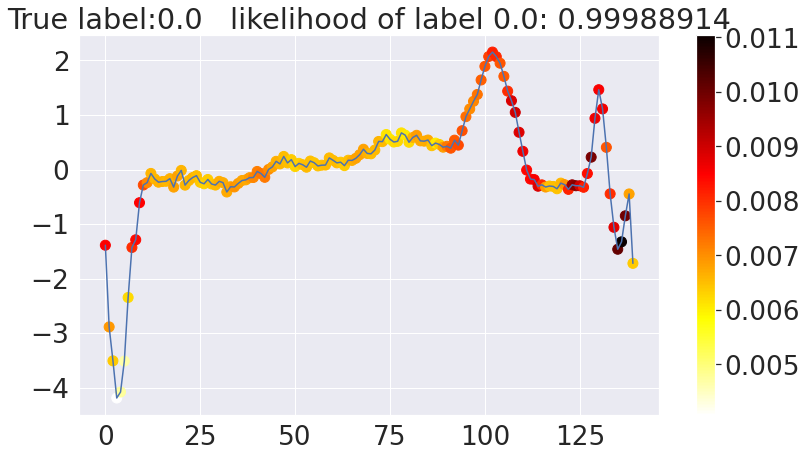

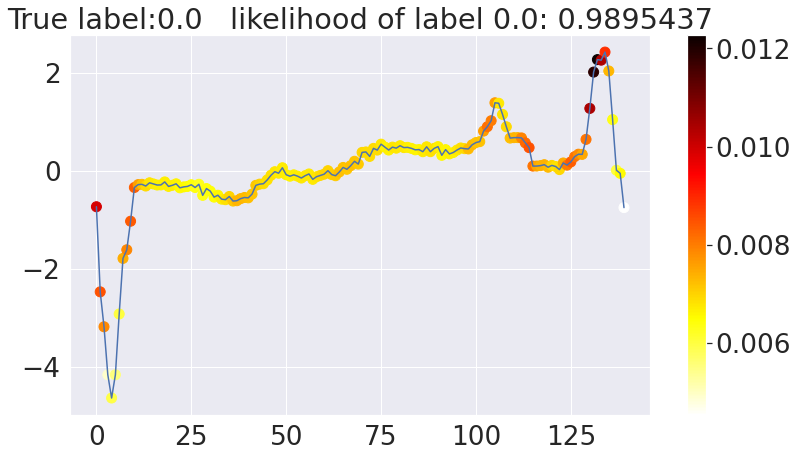

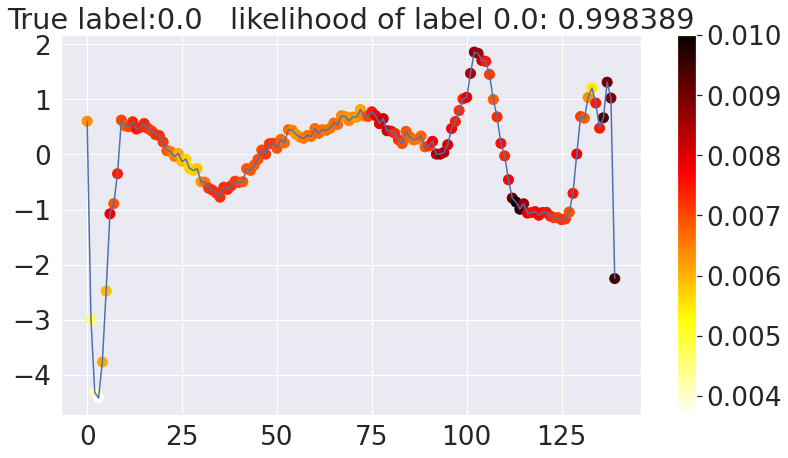

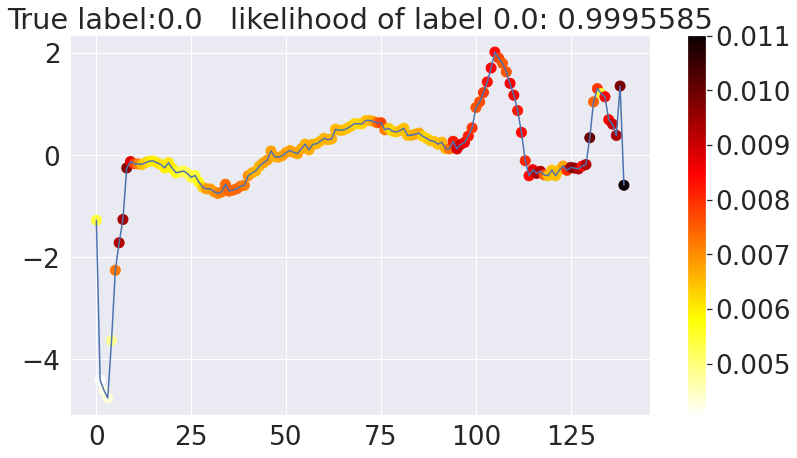

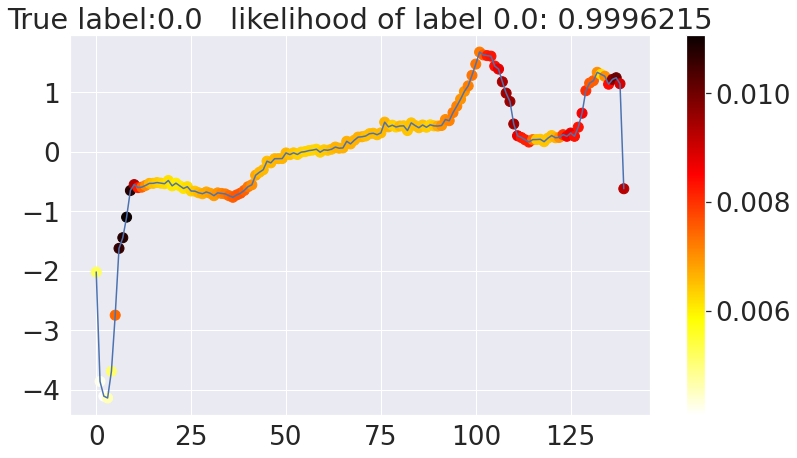

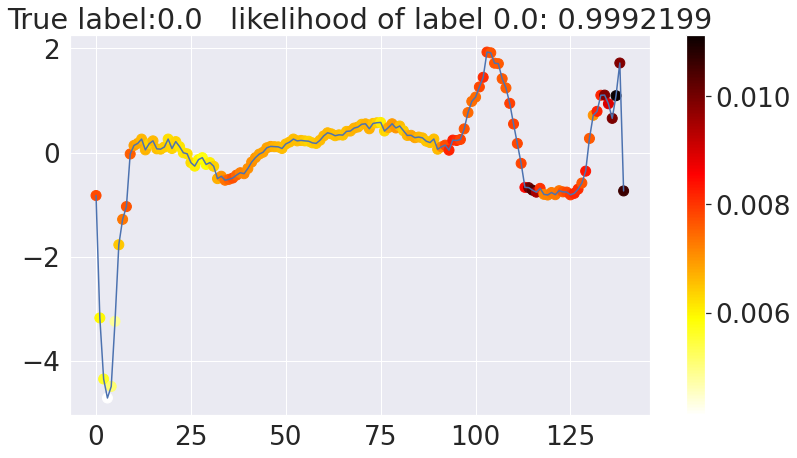

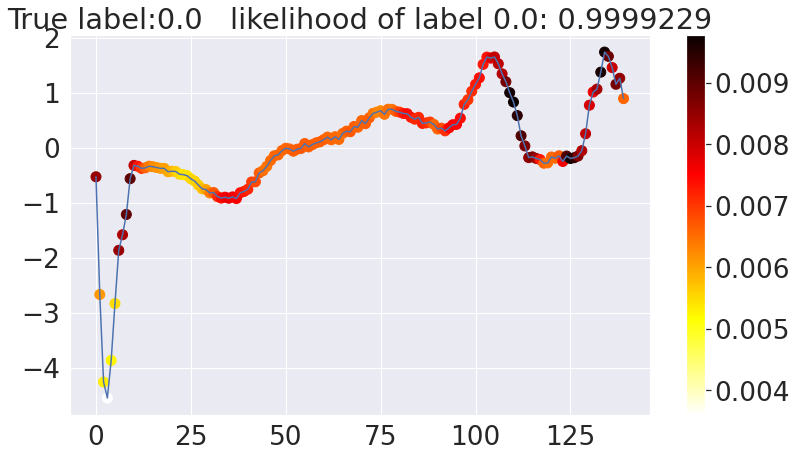

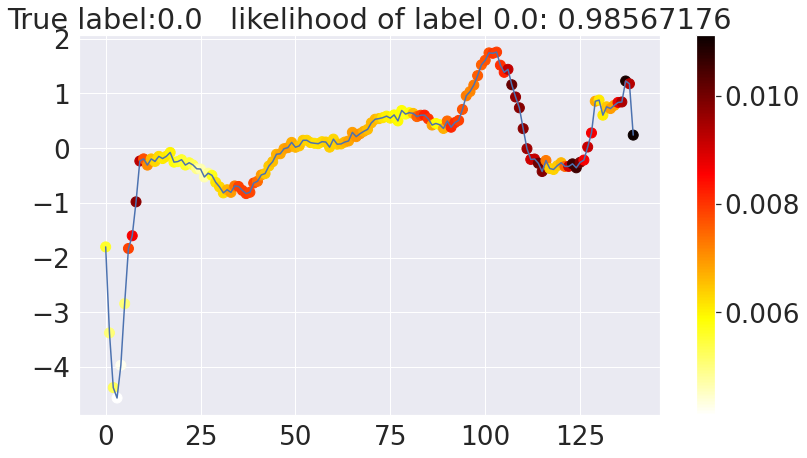

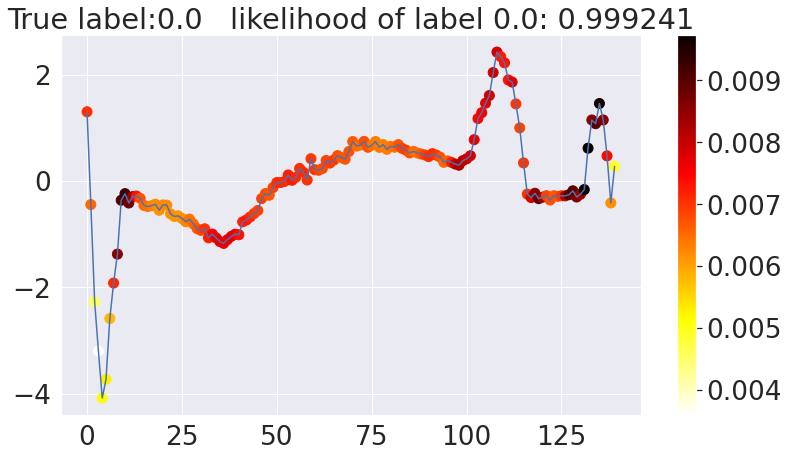

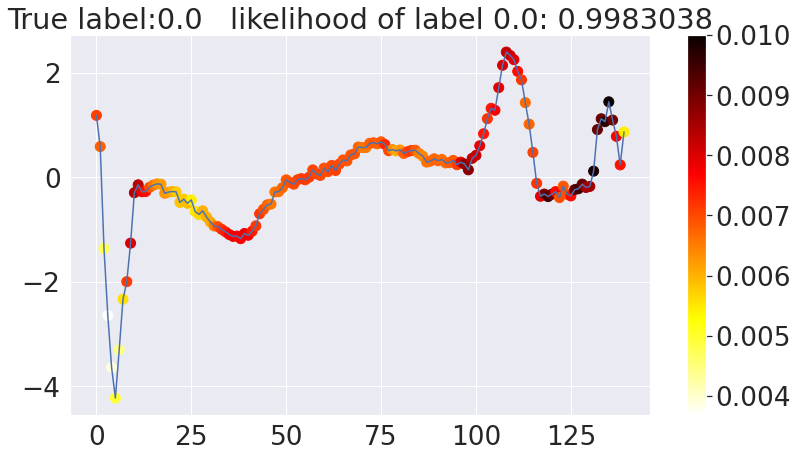

In [43]:
import matplotlib.pyplot as plt
#from matplotlib.backends.backend_pdf import PdfPages
#plt.rcParams.update({'figure.max_open_warning': 0})

get_last_conv = keras.backend.function([model.layers[0].input, keras.backend.learning_phase()], [model.layers[-3].output])
last_conv = get_last_conv([x_test[:100], 1])[0]

get_softmax = keras.backend.function([model.layers[0].input, keras.backend.learning_phase()], [model.layers[-1].output])
softmax = get_softmax(([x_test[:100], 1]))[0]
softmax_weight = model.get_weights()[-2]
CAM = np.dot(last_conv, softmax_weight)


#pp = PdfPages('CAM.pdf')
for k in range(20):
    CAM = (CAM - CAM.min(axis=1, keepdims=True)) / (CAM.max(axis=1, keepdims=True) - CAM.min(axis=1, keepdims=True))
    c = np.exp(CAM) / np.sum(np.exp(CAM), axis=1, keepdims=True)
    plt.figure(figsize=(13, 7));
    plt.plot(x_test[k].squeeze());
    plt.scatter(np.arange(len(x_test[k])), x_test[k].squeeze(), cmap='hot_r', c=c[k, :, :, int(y_test[k])].squeeze(), s=100);
    plt.title(
        'True label:' + str(y_test[k]) + '   likelihood of label ' + str(y_test[k]) + ': ' + str(softmax[k][int(y_test[k])]))
    plt.colorbar();
    plt.show()
    #plt.close('all')
    #pp.savefig()